In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from scipy.sparse import csr_matrix

In [2]:
df = pd.read_csv('log2.csv') 
df


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18
...,...,...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,allow,314,192,122,6,15,4,2
65528,50964,80,13485,80,allow,4680740,67312,4613428,4675,77,985,3690
65529,54871,445,0,0,drop,70,70,0,1,0,1,0
65530,54870,445,0,0,drop,70,70,0,1,0,1,0


In [3]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

le = LabelEncoder()
df['Action'] = le.fit_transform(df['Action'])
df

mapping = dict(zip(le.classes_, le.transform(le.classes_)))

print('Mapping:\n', mapping)


Mapping:
 {'allow': 0, 'deny': 1, 'drop': 2, 'reset-both': 3}


In [4]:
columns_to_encode = ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port']

df_encoded = pd.get_dummies(df, columns=columns_to_encode, prefix=columns_to_encode)

df_encoded

,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Source Port_0,Source Port_5,...,NAT Destination Port_64932,NAT Destination Port_65054,NAT Destination Port_65100,NAT Destination Port_65128,NAT Destination Port_65253,NAT Destination Port_65264,NAT Destination Port_65387,NAT Destination Port_65427,NAT Destination Port_65534,NAT Destination Port_65535
0,0,177,94,83,2,30,1,1,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,4768,1600,3168,19,17,10,9,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,238,118,120,2,1199,1,1,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,3327,1438,1889,15,17,8,7,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,25358,6778,18580,31,16,13,18,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65527,0,314,192,122,6,15,4,2,False,False,...,False,False,False,False,False,False,False,False,False,False
65528,0,4680740,67312,4613428,4675,77,985,3690,False,False,...,False,False,False,False,False,False,False,False,False,False
65529,2,70,70,0,1,0,1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
65530,2,70,70,0,1,0,1,0,False,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
df_encoded_numerical = df_encoded.apply(lambda col: col.astype(int))
df_encoded_numerical

,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Source Port_0,Source Port_5,...,NAT Destination Port_64932,NAT Destination Port_65054,NAT Destination Port_65100,NAT Destination Port_65128,NAT Destination Port_65253,NAT Destination Port_65264,NAT Destination Port_65387,NAT Destination Port_65427,NAT Destination Port_65534,NAT Destination Port_65535
0,0,177,94,83,2,30,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,4768,1600,3168,19,17,10,9,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,238,118,120,2,1199,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,3327,1438,1889,15,17,8,7,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,25358,6778,18580,31,16,13,18,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65527,0,314,192,122,6,15,4,2,0,0,...,0,0,0,0,0,0,0,0,0,0
65528,0,4680740,67312,4613428,4675,77,985,3690,0,0,...,0,0,0,0,0,0,0,0,0,0
65529,2,70,70,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65530,2,70,70,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = df_encoded_numerical.drop(columns=['Action']) 
y = df_encoded_numerical['Action'] 

X_sparse = csr_matrix(X)

X_train, X_test, y_train, y_test = train_test_split(X_sparse, 
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [17]:
model = LinearSVC()

model.fit(X_train, y_train)

svm_predictions = model.predict(X_test)


C:\Users\austi\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


SVM Accuracy: 0.9583428702220188


C:\Users\austi\anaconda3\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [18]:
svm_accuracy = accuracy_score(y_test, svm_predictions)
print('SVM Accuracy:', svm_accuracy)

SVM Accuracy: 0.9583428702220188


In [19]:
print('SVM Classification Report:')
print(classification_report(y_test, svm_predictions))

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      7545
           1       1.00      1.00      1.00      2994
           2       1.00      1.00      1.00      2562
           3       0.00      0.00      0.00         6

    accuracy                           0.96     13107
   macro avg       0.75      0.73      0.74     13107
weighted avg       1.00      0.96      0.98     13107



In [20]:
svm_conf_matrix = confusion_matrix(y_test, svm_predictions)
svm_conf_matrix

array([[7012,   11,    0,  522],
       [   0, 2987,    7,    0],
       [   0,    0, 2562,    0],
       [   3,    3,    0,    0]], dtype=int64)

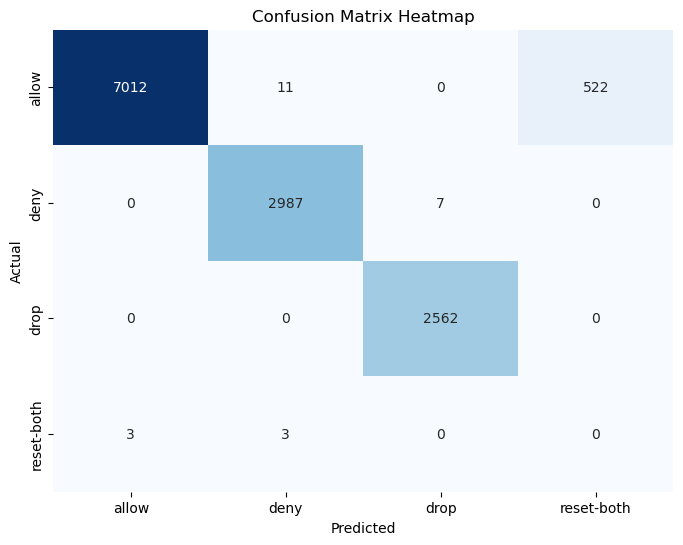

In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(svm_conf_matrix, 
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = ['allow', 'deny', 'drop', 'reset-both'], 
            yticklabels = ['allow', 'deny', 'drop', 'reset-both'],
            cbar = False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [25]:
sgd_model = SGDClassifier()
sgd_model.fit(X_train, y_train)
sgd_predictions = sgd_model.predict(X_test)

In [26]:
sgd_accuracy = accuracy_score(y_test, sgd_predictions)
print('SGD Accuracy:', sgd_accuracy)

SGD Accuracy: 0.9651331349660487


In [27]:
print('SGD Classification Report:')
print(classification_report(y_test, sgd_predictions))

SGD Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7545
           1       1.00      0.86      0.92      2994
           2       0.85      1.00      0.92      2562
           3       0.00      0.00      0.00         6

    accuracy                           0.97     13107
   macro avg       0.71      0.71      0.71     13107
weighted avg       0.97      0.97      0.97     13107



C:\Users\austi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\austi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\austi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
sgd_conf_matrix = confusion_matrix(y_test, sgd_predictions)
sgd_conf_matrix

array([[7520,    0,   25,    0],
       [   0, 2568,  426,    0],
       [   0,    0, 2562,    0],
       [   3,    1,    2,    0]], dtype=int64)

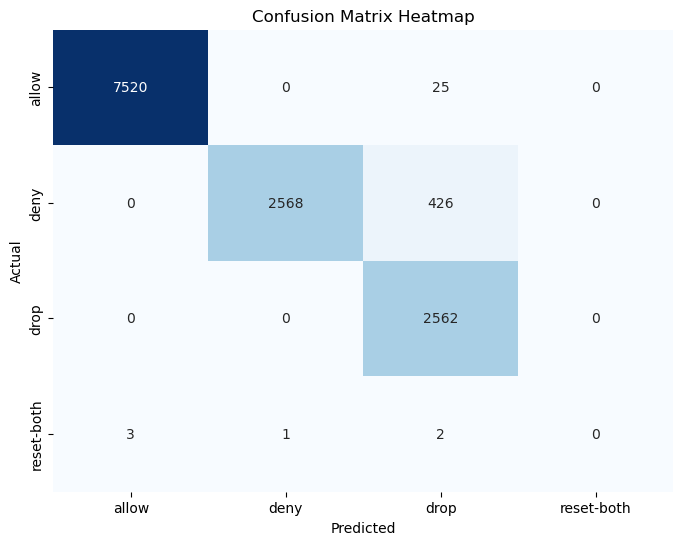

In [29]:
plt.figure(figsize=(8, 6))
sns.heatmap(sgd_conf_matrix, 
            annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = ['allow', 'deny', 'drop', 'reset-both'], 
            yticklabels = ['allow', 'deny', 'drop', 'reset-both'],
            cbar = False)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


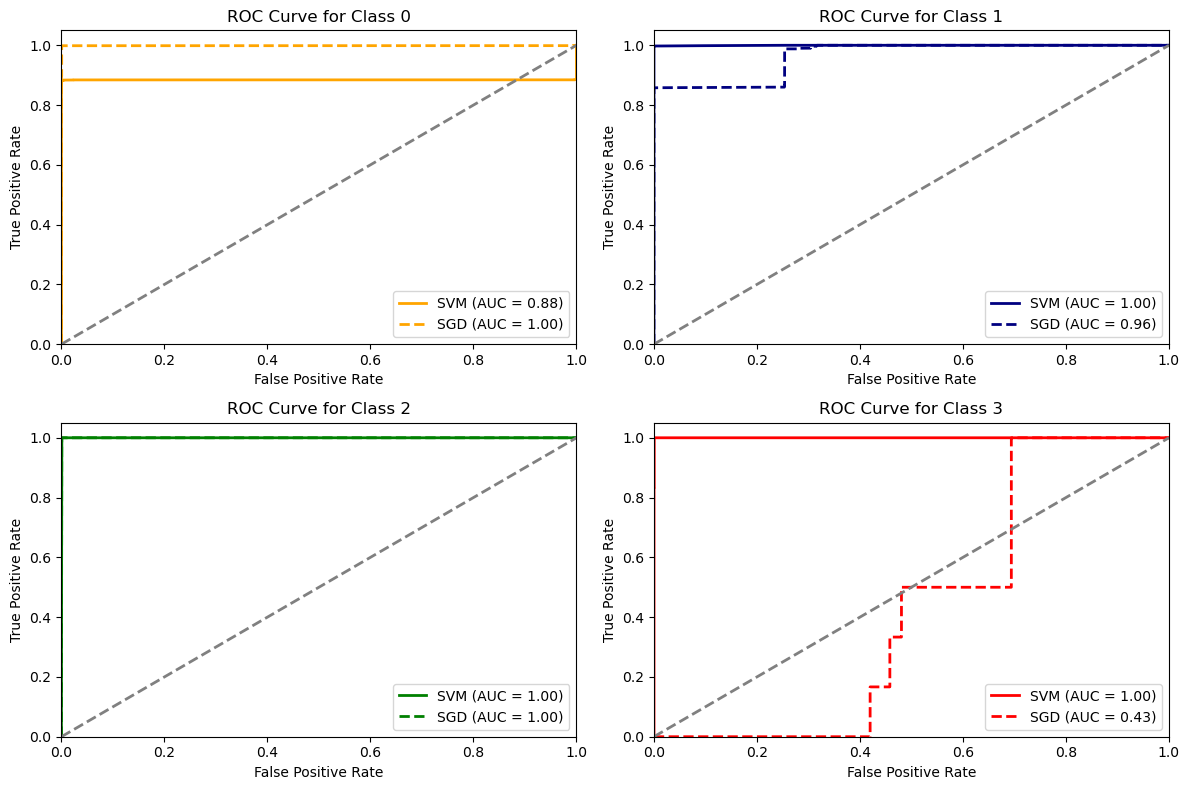

In [30]:
#### is auc a good way to view this??
#### i think so if split up like htis

y_test_binarized = label_binarize(y_test, classes = [0, 1, 2, 3])

svm_probs = model.decision_function(X_test)
sgd_probs = sgd_model.decision_function(X_test)

n_classes = 4
fpr_svm = dict()
tpr_svm = dict()
roc_auc_svm = dict()

fpr_sgd = dict()
tpr_sgd = dict()
roc_auc_sgd = dict()

plt.figure(figsize=(12, 8))

colors = ['orange', 'navy', 'green', 'red']

for i in range(n_classes):
    plt.subplot(2, 2, i + 1)  
    fpr_svm[i], tpr_svm[i], _ = roc_curve(y_test_binarized[:, i], svm_probs[:, i])
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])
    
    fpr_sgd[i], tpr_sgd[i], _ = roc_curve(y_test_binarized[:, i], sgd_probs[:, i])
    roc_auc_sgd[i] = auc(fpr_sgd[i], tpr_sgd[i])
    
    plt.plot(fpr_svm[i], 
             tpr_svm[i],
             color = colors[i],
             lw = 2,
             label = f'SVM (AUC = {roc_auc_svm[i]:.2f})')
    
    plt.plot(fpr_sgd[i],
             tpr_sgd[i],
             color = colors[i],
             linestyle = '--', 
             lw = 2,
             label = f'SGD (AUC = {roc_auc_sgd[i]:.2f})')
    
    plt.plot([0, 1], 
             [0, 1],
             color = 'gray', 
             lw = 2,
             linestyle = '--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class {i}')
    plt.legend(loc = 'lower right')

plt.tight_layout()
plt.show()
